In [1]:
import pybar.pybar as pybar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import cm
import pandas as pd
from tqdm import tqdm
import functions as f
from pathlib import Path

In [2]:
beta = np.deg2rad(10)
i    = np.deg2rad(50)
to_Myr = 9.78462

In [3]:
t = 20
X, Y, VX, VY, RHO = np.load(f'./../simulation/simulation/output_npy/data_{t}.npy')
FIG_DIR = Path('./../figures/')

In [4]:
VX, VY = f.add_solid_body_rotation(X, Y, VX, VY, 0.4)
X, Y, VX, VY = f.rotate_bar(beta, X, Y, VX, VY)
X, Y, VR = f.incline_galaxy(i, X, Y, VX, VY)

### pixelation

In [5]:
step = 0.1
RHO_array          = f.mean_in_pixel(X, Y, step, RHO)
VR_array          = f.mean_in_pixel(X, Y, step, VR * RHO) / RHO_array

x_center_array, y_center_array = f.centers_of_pixel(X, Y, step)

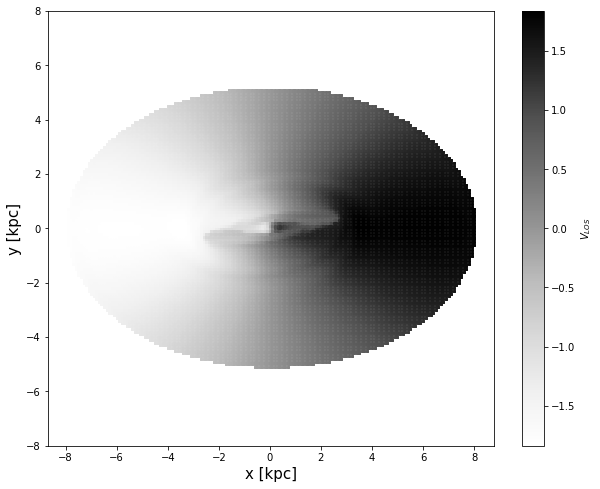

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

levels = np.linspace(np.nanmin(VR_array), np.nanmax(VR_array), 101)
norm = mc.BoundaryNorm(levels, 256)

sc = ax.scatter(x_center_array, y_center_array, c=VR_array, 
                cmap='Greys', marker='s', s=4)
ax.set_xlabel('x [kpc]', fontsize=15)
ax.set_ylabel('y [kpc]', fontsize=15)
ax.set_ylim(-8, 8)
plt.colorbar(sc, label=r'$V_{LOS}$')

### integrating

In [7]:
VR_array_ = f.make_symmetric(x_center_array, VR_array)
RHO_array_ = f.make_symmetric(x_center_array, RHO_array)

In [8]:
bar = pybar.mybar(Flux=RHO_array_,
                  Velocity=VR_array_,
                  Yin=y_center_array, Xin = x_center_array,
                  inclin=np.rad2deg(i), PAnodes=90)

In [9]:
bar.tremaine_weinberg(slit_width=step)

In [10]:
x_tw = bar.dfx_tw
v_tw = bar.dfV_tw

In [11]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021/bin/universal-darwin'
#print(os.getenv("PATH"))

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=True)

In [12]:
plasma = cm.get_cmap('plasma', len(x_tw))
colors = plasma.colors

In [13]:
# mask_not_center = (y_center_array[0, :-1] < -0.7) | (y_center_array[0, :-1] > 0.7)

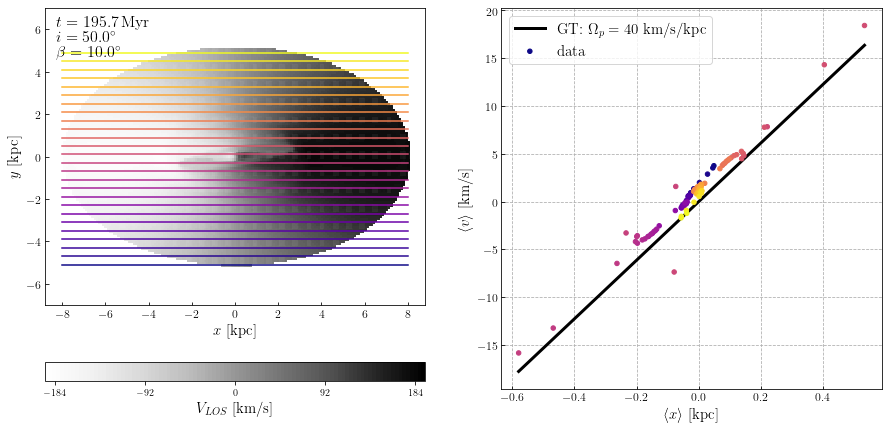

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

levels = np.linspace(np.nanmin(VR_array) * 100 - 10, np.nanmax(VR_array) * 100 + 10, 101)
cbarticks = np.linspace(np.nanmin(VR_array).round(2) * 100 , np.nanmax(VR_array).round(2) * 100 , 5)
norm = mc.BoundaryNorm(levels, 256)

ax1 = ax[0]
ax2 = ax[1]

sc = ax1.scatter(x_center_array, y_center_array, c=VR_array * 100, 
                 cmap='Greys', norm=norm, marker='s', s=3)
for index, y in enumerate(y_center_array[0,:-1]):
    if index % 4 == 0:
        ax1.plot([-8, 8], [y, y], c=colors[index])
ax1.set_xlabel(r'$x$ [kpc]', fontsize=15)
ax1.set_ylabel(r'$y$ [kpc]', fontsize=15)
ax1.tick_params(labelsize=12, direction='in')
ax1.annotate(r'$t=%.1f\, \rm Myr$' % (t * to_Myr), xy=(0.03, 0.94),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)), xy=(0.03, 0.89),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$\beta=%.1f ^{\circ}$' % (np.rad2deg(beta)), xy=(0.03, 0.84),
             xycoords='axes fraction', fontsize=16, color='k')

ax1.set_ylim(-7, 7)
cbar = plt.colorbar(sc, ax=ax1, orientation="horizontal", fraction=0.07, ticks=cbarticks)
cbar.set_label(label=r'$V_{LOS}$ [km/s]', size=15)

ax2.plot([np.nanmin(x_tw), np.nanmax(x_tw)], [np.nanmin(x_tw) * 40 * np.sin(i), np.nanmax(x_tw) * 40 * np.sin(i)], 
        c='black', lw=3, label=r'GT: $\Omega_p = 40$ km/s/kpc')
ax2.scatter(x_tw, v_tw * 100, s=20, c=colors, label=r'data', zorder=100)

# ax2.set_ylim(-3, 3)
# ax2.set_xlim(-0.1, 0.1)
ax2.tick_params(labelsize=12,direction='in')
ax2.set_xlabel(r' $\langle x \rangle$ [kpc]', fontsize=15)
ax2.set_ylabel(r' $\langle v \rangle$ [km/s]', fontsize=15)
ax2.legend(fontsize=15, loc='upper left')
ax2.grid(ls='dashed')
plt.savefig(FIG_DIR / 'TW_method_pybar.png', bbox_inches='tight', dpi=300)